C:\Users\sdpat\AppData\Local\Temp\ipykernel_17980\2257438590.py:63: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


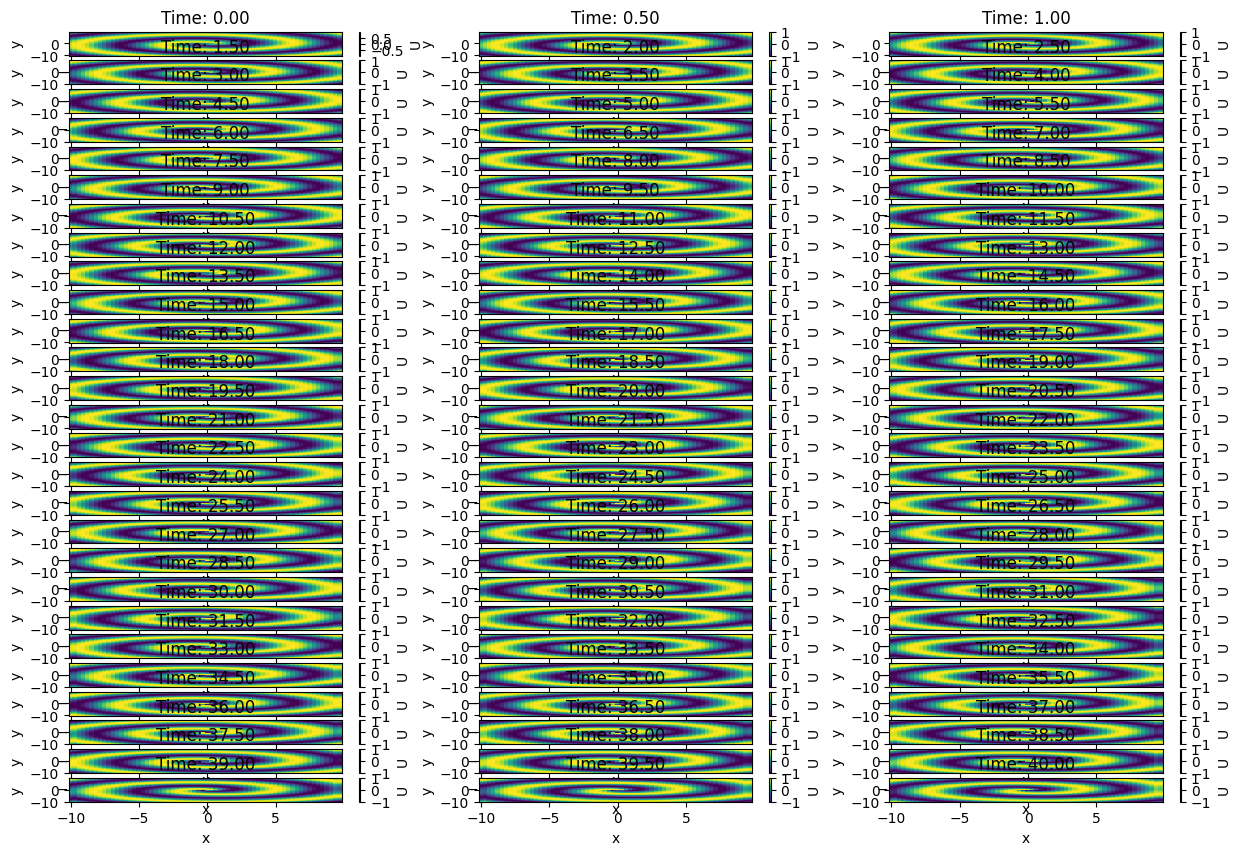

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft2, ifft2
from scipy.integrate import solve_ivp
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Parameters
beta = 1
D1, D2 = 0.1, 0.1
Lx, Ly = 20, 20
nx, ny = 64, 64
x = np.linspace(-Lx / 2, Lx / 2, nx, endpoint=False)
y = np.linspace(-Ly / 2, Ly / 2, ny, endpoint=False)
X, Y = np.meshgrid(x, y)
k = (2 * np.pi / Lx) * np.fft.fftfreq(nx, d=(Lx / nx))
kx, ky = np.meshgrid(k, k)
k2 = kx**2 + ky**2
k2[0, 0] = 1e-6  # Prevent division by zero

# Initial conditions: spiral
m = 1
U0 = np.tanh(np.sqrt(X**2 + Y**2)) * np.cos(m * np.angle(X + 1j * Y) - np.sqrt(X**2 + Y**2))
V0 = np.tanh(np.sqrt(X**2 + Y**2)) * np.sin(m * np.angle(X + 1j * Y) - np.sqrt(X**2 + Y**2))
U_hat0 = fft2(U0)
V_hat0 = fft2(V0)

# RHS function
def reaction_diffusion(t, W_hat_flat):
    U_hat, V_hat = W_hat_flat[:nx * ny].reshape((nx, ny)), W_hat_flat[nx * ny:].reshape((nx, ny))
    U = np.real(ifft2(U_hat))
    V = np.real(ifft2(V_hat))
    A2 = U**2 + V**2
    lambda_A = 1 - A2
    omega_A = -beta * A2
    U_hat_t = fft2(lambda_A * U - omega_A * V) - D1 * k2 * U_hat
    V_hat_t = fft2(omega_A * U + lambda_A * V) - D2 * k2 * V_hat
    return np.hstack([U_hat_t.ravel(), V_hat_t.ravel()])

# Solve the system
W_hat0 = np.hstack([U_hat0.ravel(), V_hat0.ravel()])
t_span = (0, 40)
t_eval = np.arange(0, 40.5, 0.5)
solution = solve_ivp(reaction_diffusion, t_span, W_hat0, method='RK45', t_eval=t_eval)

# Modify to generate subplots for all time steps in a single figure
plt.figure(figsize=(15, 10))
num_plots = len(t_eval)
cols = 3  # Number of columns for subplots
rows = (num_plots + cols - 1) // cols  # Compute number of rows needed

for i, t in enumerate(t_eval):
    U_hat = solution.y[:nx * ny, i].reshape((nx, ny)) + 1j * solution.y[nx * ny:2 * nx * ny, i].reshape((nx, ny))
    U = np.real(ifft2(U_hat))
    
    plt.subplot(rows, cols, i + 1)
    plt.pcolor(x, y, U, shading='auto')
    plt.title(f'Time: {t:.2f}')
    plt.colorbar(label='U')
    plt.xlabel('x')
    plt.ylabel('y')

plt.tight_layout()
plt.show()


In [11]:
fig, ax = plt.subplots(figsize=(8, 6))
c = ax.pcolor(x, y, np.zeros((nx, ny)), shading='auto', cmap='viridis')
fig.colorbar(c, ax=ax)
time_text = ax.text(0.05, 0.95, '', transform=ax.transAxes, color='white', fontsize=12)

# Define the update function for the animation
def update(frame):
    # Extract U_hat and compute U for the current frame
    U_hat = solution.y[:nx * ny, frame].reshape((nx, ny)) + 1j * solution.y[nx * ny:2 * nx * ny, frame].reshape((nx, ny))
    U = np.real(ifft2(U_hat))
    
    # Update the plot and time text
    c.set_array(U.ravel())
    time_text.set_text(f'Time: {t_eval[frame]:.2f}')
    return c, time_text

# Create the animation
ani = FuncAnimation(fig, update, frames=len(t_eval), interval=100, blit=False)

# Display the animation in the notebook
plt.close(fig)
HTML(ani.to_jshtml())